In [1]:
using JLD
using PyPlot

In [2]:
nombrecm="../JLDFiles/TrabajandoCentrosdeMasa/140116s2cut2_evento_2-CM.jld"
archivo=load(nombrecm)
DatosCMP=archivo["CMP"]
DatosCMN=archivo["CMN"];

In [4]:
function leeunmegaarrayarchivos(NomineGeneralis::AbstractString, desde=35, hasta=501)
    LeMegaArray=Array[]
    for t=desde:hasta
      #  println("$NomineGeneralis-$t.dat")
        CMx=try 
            readdlm("$NomineGeneralis-$t.dat")
        catch
            []
        end
        push!(LeMegaArray, CMx)
    end
    return LeMegaArray
    end


function leunjlddeCM(datos, desde=1, hasta=300)
    LeMegaArray=Array[]
    for t=desde:hasta
      #  println("$NomineGeneralis-$t.dat")
        CMx=try 
        readdlm("$NomineGeneralis-$t.dat")
        catch
            []
        end
        push!(LeMegaArray, CMx)
    end
    return LeMegaArray
end



leunjlddeCM (generic function with 3 methods)

In [7]:
DatosCMP[1215]

12×3 Array{Float64,2}:
 63.8956  27.2959    219.36  
 37.3098   3.71639   138.805 
 61.5676  14.0156    530.718 
 50.146   12.7569    329.624 
 37.566   51.4557    719.828 
 58.1263  24.814     183.016 
 61.431   39.5778   1466.76  
 58.8491  30.8842    865.674 
 43.0749   6.39378   287.562 
 51.4075  47.679     231.304 
 53.6452  17.0691    363.711 
 63.2543  22.2588     94.3558

In [8]:
function dist2D(x,y)
    result=sqrt((x[1]-y[1])^2+(x[2]-y[2])^2)
    return result
end

function difgordis(x,y)
    result=abs(x-y)/max(abs(x),abs(y))
    return result
end

difgordis (generic function with 1 method)

In [9]:
difgordis(0.21,0.29)

0.27586206896551724

In [10]:
function encuentraTrayectorias(Datos, mincadena=20, mingordo=2.0, desde=1,hasta=20)

toleradist=16.0*sqrt(2)
#toldifgordis=0.33
tau=1
t=1
j=1
Catenario=Dict{Integer, Array{Any}}()
Cadena=[0 0 0 0]
tnum=1
CopiaMegaArray=deepcopy(Datos);
NumFrames=length(Datos)
FakeNumFrames=NumFrames



while t <= FakeNumFrames-1 
    
    tau=t
    
    @label arrrrh
 
        if(CopiaMegaArray[tau]==[])
            
            jmax,nada=0,0
        else
          
     jmax,nada= size(CopiaMegaArray[tau])
        end
    
        
    while j <=jmax && tau<FakeNumFrames
            
            if abs(CopiaMegaArray[tau][j,3]) > mingordo
                
            Eslabon=[transpose(CopiaMegaArray[tau][j,:]) tau]
            Cadena=vcat(Cadena, Eslabon)
         #   println("Papa t: ", t, "  tau: ", tau, " y  j: ",j )
            mindist=2
            kasterisco=1
                
                if CopiaMegaArray[tau+1]==[]
                    kmax,nada=0,0
                else
                kmax, nada= size(CopiaMegaArray[tau+1])
                end
                huboalgo=false
          
        #    kmax=5
            
            for k=1:kmax
                
                EslabonTentativo=CopiaMegaArray[tau+1][k,:]
            #    println(EslabonTentativo)
                    if abs(EslabonTentativo[3])>mingordo
                    dist=dist2D(Eslabon,EslabonTentativo)                  
                    if dist<mindist
                        mindist=dist
                        kasterisco=k
                        
                       # println(kasterisco, "=k*", k, "=k")
                        huboalgo=true
                    end
                end
            
            end    
            
            if huboalgo && mindist<toleradist
                #quitamos el anterior
                CopiaMegaArray[tau][j,3]=0.0000 
               # println(mindist," ", t, " ", tau+1 ," ", kasterisco )
                
                if tau+1<FakeNumFrames
                    tau+=1
                    j=kasterisco
      #              println("Pepe t: ", t, "  tau: ", tau, " y  j: ",j )
                    @goto arrrrh
                
                else
                    
                    Eslabon=[transpose(CopiaMegaArray[tau+1][kasterisco,:]) tau+1]
                    Cadena=vcat(Cadena, Eslabon)
      #              println("Pipi t: ", t, "  t: ", t, " y  j: ",j )
                    j+=1
                    tau=t
                    
                    if size(Cadena)[1]>mincadena
                        #push!(Catenario, Cadena[2:end,:])
                        Catenario[tnum]=Cadena[2:end,:]
                        tnum+=1
                    end
                    
                    Cadena=[0 0 0 0]
                    @goto arrrrh
                end
                                
            else
                
                if size(Cadena)[1]>mincadena
                    # veamos si funciona  mejor como dict 
                        #push!(Catenario, Cadena[2:end,:])
                        Catenario[tnum]=Cadena[2:end,:]
                        tnum+=1
                end
                Cadena=[0 0 0 0]
                j+=1
                tau=t
                @goto arrrrh
            end
                       
        end #cierra sobre el if de  la masa 
                
        j+=1                    
        tau=t
    
    end
    @label urrr
      
    j=1
    t+=1
    tau=t
    Cadena=[0 0 0 0]
        end 
    
    return Catenario
end

encuentraTrayectorias (generic function with 5 methods)

In [11]:
#Recuerda el segundo argumento es la longitud mínima de la cadena
@time CatenarioPositivo=encuentraTrayectorias(DatosCMP,5,20,2,2000);


  1.797707 seconds (1.37 M allocations: 53.930 MiB, 0.83% gc time)


In [12]:
CatenarioNegativo=encuentraTrayectorias(DatosCMN,3,100,2,2000);

In [13]:
nombreout=nombrecm[1:end-6]*"Tray-altas.jld"
save(nombreout, "CatenarioNegativo", CatenarioNegativo, "CatenarioPositivo", CatenarioPositivo)

In [14]:
length(CatenarioPositivo), length(CatenarioNegativo)

(211, 257)

In [15]:
nombreout

"../JLDFiles/TrabajandoCentrosdeMasa/140116s2cut2_evento_2-Tray-altas.jld"

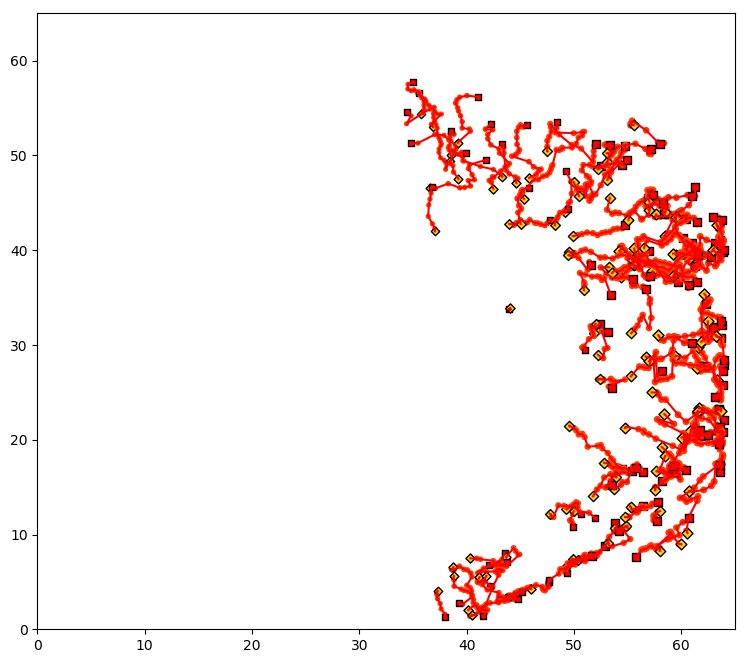

In [17]:
PyPlot.ion()
figure(figsize=(9,8))
#axis("equal")
xlim(0.0,65.0)
ylim(0.0,65.0)
tolerancia=25
minlong=7
maxlong=100
#colores=Union{}

for p in values(CatenarioPositivo)
    gordura=abs(p[:3])
    longus,gordus=size(p)
    if (mean(gordura)>tolerancia) && (longus>minlong) && longus < maxlong
        #Si son chiquitos no nos interesan.
        xxpos=p[:,1]
        yypos=p[:,2]    
        tiempos=p[:,4]/7022    
        plot(xxpos, yypos, marker="o", markersize=0.25, color="r")
        colores=scatter(xxpos,yypos, s=gordura*0.4, edgecolors="none", 
        c=tiempos, cmap="autumn", vmin=0.0, vmax=0.72 )
        principios=scatter(xxpos[1],yypos[1], s=gordura*0.5,
        edgecolors="black", 
        color="r", marker="s", label="Inicio" )
        finales=scatter(xxpos[end],yypos[end], s=gordura*0.5, edgecolors="black", 
        color="gold", marker="D", label="Final" )
        # annotate(round(tiempos[1],4),  (xxpos[1], yypos[1]), fontsize=7, color="black")
        # annotate(round(tiempos[end],4), (xxpos[end], yypos[end]), fontsize=7, color="green")

    end
end

savefig("ejemploaltaspositivas-01.svg",dpi=92)

In [36]:
values(CatenarioNegativo)

Base.ValueIterator for a Dict{Integer,Array{Any,N} where N} with 2111 entries. Values:
  Any[53.5033 32.4076 -133.551 1621.0; 53.4892 32.7307 -136.299 1622.0; 54.1822…
  Any[55.8665 12.0067 -225.197 1672.0; 56.5207 12.1896 -224.462 1673.0; 56.4422…
  Any[6.59196 45.59 -103.91 355.0; 7.14074 46.3508 -141.1 356.0; … ; 5.35004 47…
  Any[45.0799 9.86538 -922.799 1307.0; 45.3606 10.2127 -893.363 1308.0; 45.7932…
  Any[47.305 5.74263 -285.768 1113.0; 48.9043 6.26266 -245.747 1114.0; 48.5071 …
  Any[11.6321 58.9727 -112.206 1998.0; 11.8719 59.5696 -128.812 1999.0; 10.7445…
  Any[20.1788 28.8426 -120.598 1318.0; 20.8275 28.6643 -104.927 1319.0; 18.9634…
  Any[8.32063 19.8652 -172.682 46.0; 8.5374 19.9342 -154.231 47.0; 8.4098 20.34…
  Any[55.0209 25.3078 -155.68 1597.0; 56.074 26.8711 -202.385 1598.0; … ; 55.68…
  Any[55.7124 14.0536 -2754.54 1150.0; 55.6006 13.8985 -3013.4 1151.0; 55.1074 …
  Any[7.82534 44.3645 -186.664 94.0; 7.53528 44.3108 -194.993 95.0; 7.60553 44.…
  Any[24.7877 14.4522 